# Merge all Config Manager features into one dataframe
### Step 1: Load data into pandas dataframes 
Our team has spent some time in creating features from the tables in the Microsoft Configuration Manager database. Our features are stored in separate sources for each Config Manager table that we created features from. We have two types of data sources of features that we need to join together for our model:
1. `.parquet` files in blob storage 
2. SQL views from our cloud database 

We have tracked the data source file names and SQL views using a spreadsheet, and will use this list to pull the filenames and data from our cloud database and blob storage.


In [1]:
# Import modules 
from azure.storage.blob import BlobServiceClient
import pandas as pd 
import numpy
import pyodbc
import os
import json
import time

# Function Definitions --------------

def download_blob(cred, LOCALFILENAME,
                  CONTAINERNAME, BLOBNAME):

    # Start tracking download time
    t1=time.time()

    # Instantiate a blob service instance
    blob_service_client_instance = BlobServiceClient(account_url=cred['in_the_sun'], credential=cred['fun'])
    blob_client_instance = blob_service_client_instance.get_blob_client(CONTAINERNAME, BLOBNAME, snapshot=None)

    # Create the file locally
    with open(LOCALFILENAME, "wb") as my_blob:
        blob_data = blob_client_instance.download_blob()
        blob_data.readinto(my_blob)
    
    # Notify user of download time 
    t2=time.time()
    print(("It takes %s seconds to download "+BLOBNAME) % (t2 - t1))

def connect_to_database(cred):
    ''' 
    Uses pyodbc to connect to a SQL Server database
    and returns the connection object
    '''
    # Define database driver, server, database
    driver = 'SQL SERVER'

    # Define the connection string
    conn_str = f"DRIVER={{ODBC Driver 17 for SQL Server}};SERVER={cred['server']};DATABASE={cred['db']};UID={cred['uid']};PWD={cred['pwd']}"

    # Connect to database using windows authentication 
    conn = pyodbc.connect(conn_str)

    return conn 

def get_sql_data(persist_conn_obj, sql_query):
    ''' 
    Gets rows from a table in the SQL database connection
    '''
    # Execute a query for table table
    df_pers_all = pd.read_sql_query(sql_query, persist_conn_obj)
    
    return df_pers_all

def get_creds(in_file):
    with open(in_file) as f:
        cred = json.load(f)
    return cred

# Get creds 
creds_file = 'assets/fun.json'
creds = get_creds(creds_file)


In [2]:
def get_feature_metadata():

    # Read the EDA feature metadata 
    df = pd.read_excel('assets/EDA _ Feature Engineering Tasks.xlsx', sheet_name='Features to Engineer')

    # Select only completed features 
    df['Completed? (Y/N)'] = df['Completed? (Y/N)'].apply(lambda x: x.strip())
    df = df[df['Completed? (Y/N)'] == 'Y']

    # Get only one row per view/filename
    out_df = df[['Completed dataset location', 'View/Filename', 'Keys']]
    out_df = out_df.drop_duplicates()

    return out_df

def download_all_data(metadata_df, save_directory, creds):

    # Instantiate a dictionary to accumulate dataframes
    feature_dfs = {}

    # Start a SQL connection 
    conn = connect_to_database(creds)

    # Iterate through each view/file
    for row in metadata_df.iterrows():
        
        row = row[1]

        # Download and read Blob file
        if row['Completed dataset location'] == 'Blob Storage':
            
            # Download from blob storage
            blob_name = row['View/Filename']
            file_save_name = os.path.join(save_directory, blob_name)
            download_blob(creds, file_save_name, 'configmanagertest1', blob_name)

            # Read the blob into a dataframe and add to output dict
            current_df = pd.read_parquet(file_save_name)
            feature_dfs[blob_name] = current_df

        # Download and read SQL 
        if row['Completed dataset location'] == 'SQL View':
            
            # Call SQL to get data
            view_name = row['View/Filename']
            sql_query = f'SELECT * FROM {view_name}'
            current_df = get_sql_data(conn, sql_query)

            # Add data to output dict
            feature_dfs[view_name] = current_df
            print(f'retrieved {view_name} from SQL')
    
    return feature_dfs

# Download data 
save_location = 'assets/features'
df = get_feature_metadata()
feature_datasets = download_all_data(df, save_location, creds)


It takes 0.5642592906951904 seconds to download add_remove_programs_features.parquet
It takes 0.4746592044830322 seconds to download office_addin_features.parquet


/var/folders/_m/rvvvdp755xg8_b7k34mkcsvh0000gn/T/ipykernel_1603/1074546307.py:52: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pers_all = pd.read_sql_query(sql_query, persist_conn_obj)


retrieved Machine_Enclosure_Types from SQL
It takes 0.22448301315307617 seconds to download update_summary_features.parquet


/var/folders/_m/rvvvdp755xg8_b7k34mkcsvh0000gn/T/ipykernel_1603/1074546307.py:52: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pers_all = pd.read_sql_query(sql_query, persist_conn_obj)


retrieved Battery_Health_View from SQL
It takes 0.24449729919433594 seconds to download browser_usage_features.parquet
It takes 0.12974834442138672 seconds to download computer_system_features.parquet


/var/folders/_m/rvvvdp755xg8_b7k34mkcsvh0000gn/T/ipykernel_1603/1074546307.py:52: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pers_all = pd.read_sql_query(sql_query, persist_conn_obj)


retrieved Logical_Disk_Data_View from SQL
retrieved Machine_Office_Is32Bit from SQL
retrieved Office_Readiness_View from SQL
retrieved Processor_DATA_View from SQL
It takes 0.3486652374267578 seconds to download user_count_feature.parquet
It takes 0.6190469264984131 seconds to download boot_events_parsed_features.pq
It takes 0.3127312660217285 seconds to download num_events.pq
It takes 0.2882969379425049 seconds to download operating_system_features.pq
It takes 0.2123262882232666 seconds to download pc_bios_data.pq
It takes 0.17532682418823242 seconds to download pc_memory_data.pq
It takes 0.7898619174957275 seconds to download system_disc_features.pq
It takes 1.496358871459961 seconds to download workstationstatus_features.pq


In [4]:
def view_data(in_dict):

    for key in in_dict.keys():

        dat = in_dict[key]
        print(key)
        yield dat

generator = view_data(feature_datasets)

In [24]:
current = next(generator)
current.head()

StopIteration: 

### Step 2: Join all features into one dataframe 


In [27]:
def join_all_features(features_dict, metadata_df):

    # Get the system_disc table 
    system_name = 'system_disc_features.pq'
    system_df = features_dict[system_name]

    # Iterate through each file 
    for row in metadata_df.iterrows():
        row = row[1]

        # Get the table and key on the right to join to system disc
        right_df_name = row['View/Filename']
        right_df = features_dict[right_df_name]
        right_keys = row['Keys'].split(', ')

        # skip if df is system disc
        if right_df_name == system_name:
            continue
        
        # Get the system disc key
        if ('RWB_EFFECTIVE_DATE' in right_keys) or ('created_date' in right_keys):
            left_keys = ['ItemKey', 'RWB_EFFECTIVE_DATE']
        else:
            left_keys = ['ItemKey']

        # Perform a left join for the features 
        system_df = pd.merge(system_df, right_df, 
                             how='left',
                             left_on=left_keys,
                             right_on=right_keys)
        
        if 'MachineID' in system_df.columns:
            system_df = system_df.drop('MachineID', axis=1)
        elif 'ClientItemKey' in system_df.columns:
            system_df = system_df.drop('ClientItemKey', axis=1)
        elif 'created_date' in system_df.columns:
            system_df = system_df.drop('created_date', axis=1)
        
    return system_df

final_df = join_all_features(feature_datasets, df)

# Write result to parquet 
final_df.to_parquet('assets/CM_all_features_20230804.parquet', index=False)

In [26]:
# Set the notebook to display all columns of a dataframe
pd.set_option('display.max_columns', None)

final_df.sample(10)

,ItemKey,RWB_EFFECTIVE_DATE,Is_Virtual_Machine0,Client0,Active0,Days Since Creation,Days Since Last Logon,has_powerbi,num_installed_programs,avg_software_age,num_x64addins,num_x86addins,x64add_avgloadtime,x86add_avgloadtime,has_cap_iq_add,has_factset_add,has_bluematrix_add,has_bloomberg_add,has_acrobat_add,Accessx86_addin_filesize,Excelx64_addin_filesize,Excelx86_addin_filesize,OneNotex64_addin_filesize,OneNotex86_addin_filesize,Outlookx64_addin_filesize,Outlookx86_addin_filesize,PowerPointx64_addin_filesize,PowerPointx86_addin_filesize,Publisherx86_addin_filesize,Wordx64_addin_filesize,Wordx86_addin_filesize,CaseType,created_date,num_updates,num_windows_64_os_updates,num_office_updates,Battery_Power,AC_Power,EstimatedRunTime00,MicrosoftEdgeCP_usage,chrome_usage,firefox_usage,iexplore_usage,msedge_usage,opera_usage,Model,system_type,TotalSpace_GB,FreeSpace_GB,is_32bit_office,is_64bit_office,Has32BitMacro,Has64BitMacro,Has32BitOffice97_2003Files,Has64BitOffice97_2003Files,NumCPUs,AvgProcessorNormSpeed,num_users,TotalBootDurationInMilliseconds,events,InstallDate00,LastBootUpTime00,TotalVirtualMemorySize00,InstallAge,LastBootAge,BIOS Release Date,BIOSReleaseAge,Total RAM,Total Page File Space,LastHWScan,LastHWScan_Days
890386,16815655,2023-04-27,0.0,1.0,1.0,167,3.0,0.0,42.0,234.212121,3.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,198024.0,633400.0,NaN,NaN,539816.0,3796288.0,NaN,527328.0,NaN,NaN,571280.0,Laptop,2023-04-27,3.0,0.0,0.0,NaN,NaN,NaN,0.0,100.0,0.0,0.0,0.0,0.0,Latitude 9520,x64-based PC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,30136.0,1.0,2022-11-11,2023-04-26,32490.0,235.0,69.0,2022-09-16,291.0,16492932.0,16777216.0,2023-04-26 10:16:03.000,1.0
66054,16795424,2023-04-14,0.0,1.0,1.0,1274,9.0,0.0,67.0,589.781818,2.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,198024.0,633424.0,NaN,NaN,301848.0,3557280.0,NaN,527784.0,NaN,NaN,572304.0,Desktop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,64.0,0.0,1.0,35.0,0.0,OptiPlex 5060,x64-based PC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2021-02-26,2023-04-13,33588.0,858.0,82.0,2022-11-10,236.0,16568356.0,17825792.0,2023-04-13 11:53:20.000,1.0
847338,16814940,2023-04-24,0.0,1.0,1.0,199,0.0,0.0,59.0,517.565217,7.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,805720.0,1173024.0,NaN,NaN,2134424.0,5056544.0,607696.0,1571160.0,NaN,607696.0,1615640.0,Laptop,2023-04-24,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Latitude 7320,x64-based PC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2021-06-08,2023-04-21,32490.0,756.0,74.0,2021-06-08,756.0,16492932.0,16777216.0,2023-04-21 08:01:44.000,3.0
71871,16795770,2023-02-10,1.0,1.0,1.0,1193,6.0,0.0,42.0,812.333333,3.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,198024.0,633472.0,NaN,NaN,539272.0,3797248.0,NaN,527800.0,NaN,NaN,571792.0,Desktop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,71.0,0.0,0.0,29.0,0.0,Precision Tower 3430,x64-based PC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,24191.0,2.0,2021-02-01,2023-02-10,67380.0,883.0,144.0,2022-11-10,236.0,33345560.0,35651584.0,2023-02-10 04:54:28.000,0.0
616815,16812051,2023-05-02,0.0,1.0,1.0,308,5.0,0.0,59.0,331.404255,6.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,805720.0,1173000.0,NaN,NaN,1195080.0,4373216.0,607696.0,1066928.0,NaN,607696.0,1110880.0,Laptop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,84.0,0.0,0.0,16.0,0.0,Latitude 9520,x64-based PC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,39960.0,3.0,2022-06-07,2023-05-01,32490.0,392.0,64.0,2022-10-27,250.0,16492932.0,16777216.0,2023-05-01 08:31:52.000,1.0
158506,16801041,2023-03-02,0.0,1.0,1.0,968,1.0,0.0,56.0,844.409091,6.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN,805720.0,1173072.0,NaN,NaN,1194960.0,4374256.0,607696.0,1066872.0,NaN,607696.0,1111376.0,Desktop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OptiPlex 5070,x64-based PC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,48163.0,3.0,2021-06-18,2023-03-02,33569.0,746.0,124.0,2022-11-16,230.0,16549752.0,17825792.0,2023-03-02 05:05:25.000,0.0
100880,16796959,2023-04-09,0.0,1.0,1.0,1223,10.0,0.0,59.0,845.145833,3.0,15.0,0.0,0.0,0.0,0.0,0.0

<Axes: >

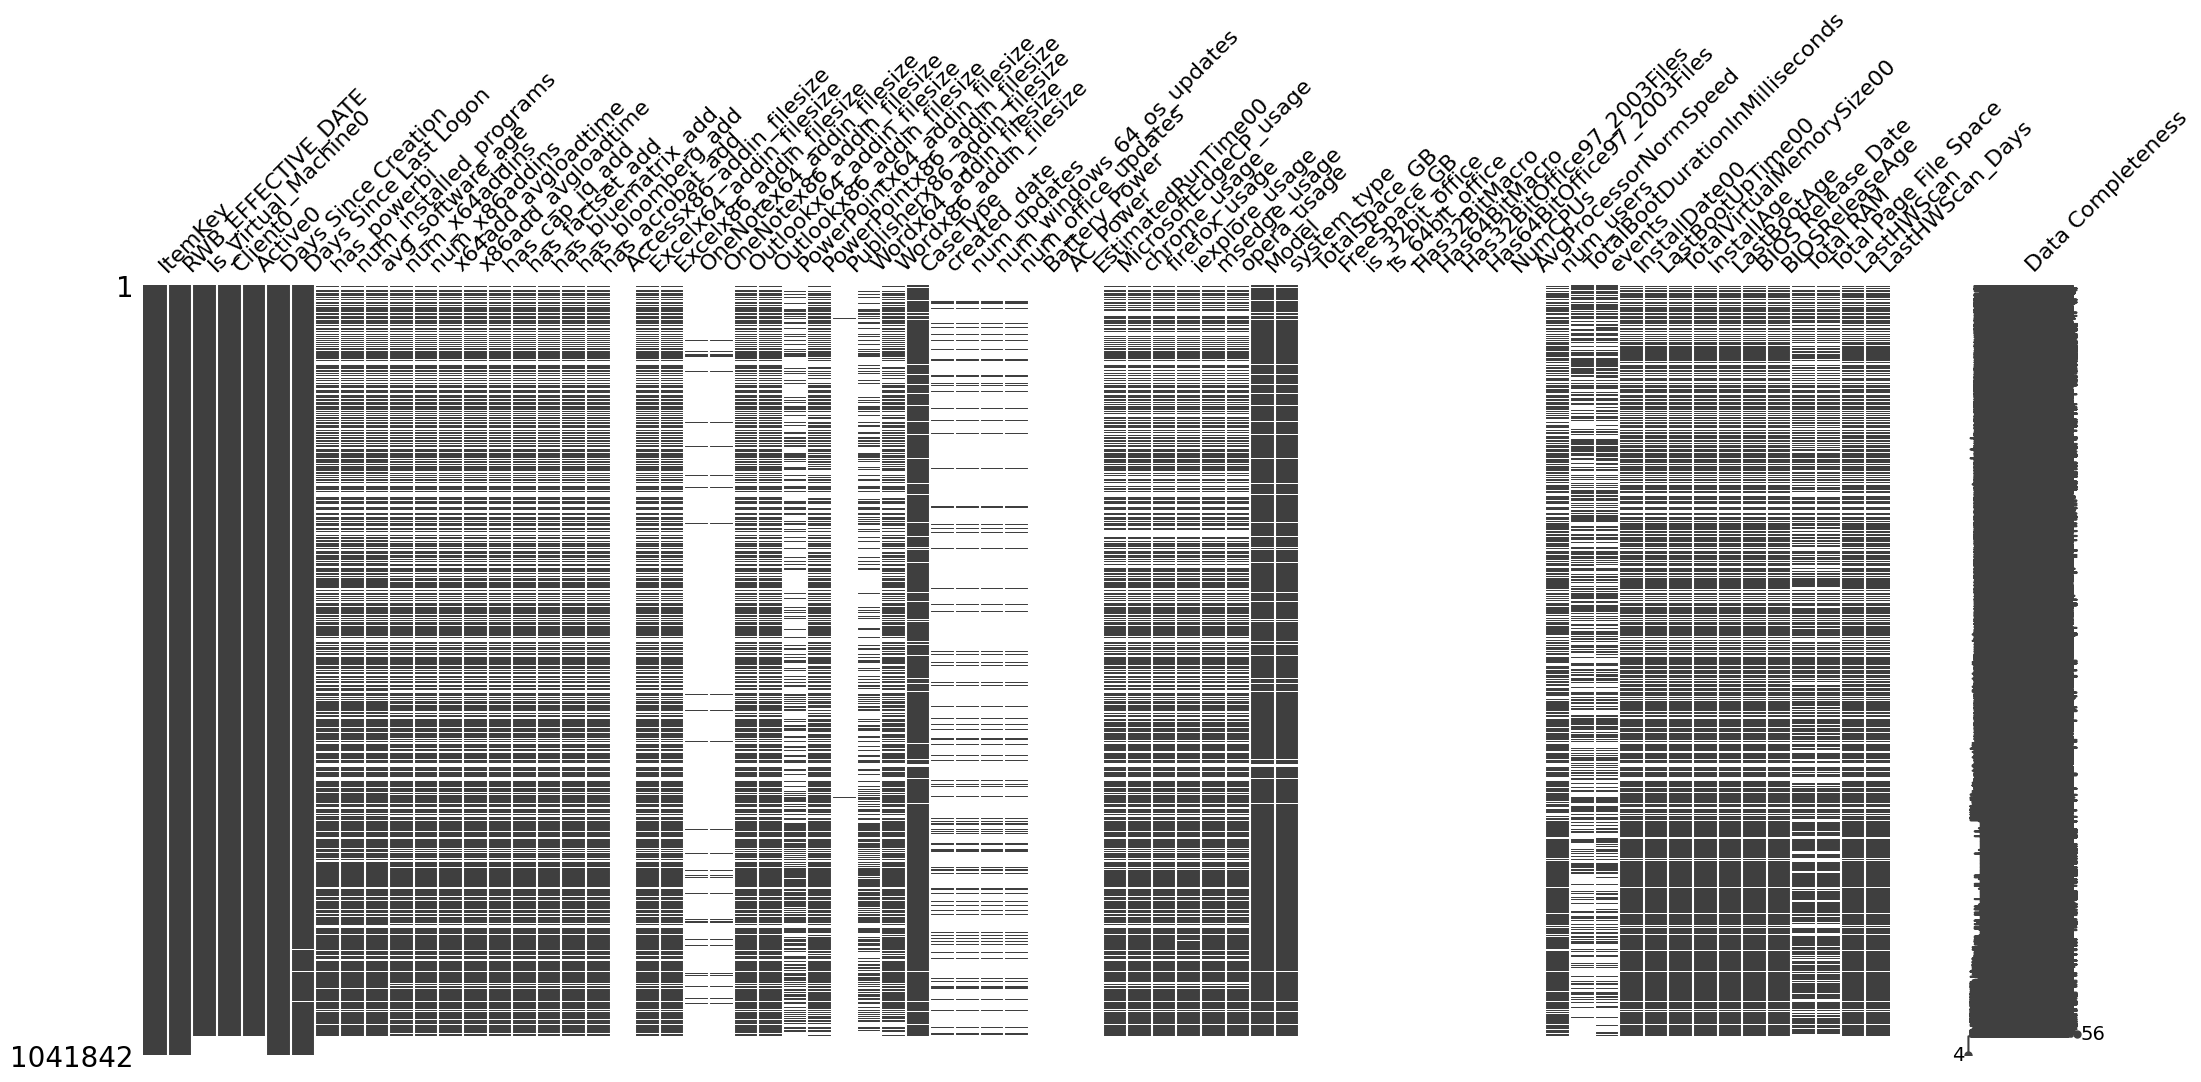

In [33]:
import missingno as msno
msno.matrix(final_df, labels=True)

In [29]:
import dtale
dtale.show(final_df).open_browser() 

### Step 3: Encode Categorical Features and Handle NaNs

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

def encode_attr(in_df, attrs):
    
    # Get the category labels and  categories
    categories = [(attr, list(in_df[attr].unique())) for attr in attrs]
    ohe_columns = [x[0] for x in categories]
    ohe_categories = [x[1] for x in categories]

    # Instantiate the one hot encoder and fit it 
    enc = OneHotEncoder(sparse_output=False, categories=ohe_categories)
    transformer = make_column_transformer((enc, ohe_columns), remainder='passthrough')
    output = transformer.fit_transform(in_df)

    # Put results in dataframe and clean up columns
    out_df = pd.DataFrame(output, columns=transformer.get_feature_names_out())
    remainder_cols =  [col[11:] for col in out_df.columns if 'remainder' in col]
    encoded_cols = [col[15:] for col in out_df.columns if 'onehotencoder' in col]
    out_df.columns = encoded_cols + remainder_cols
    out_df = out_df[remainder_cols + encoded_cols]

    return out_df